### Outer Solar System Timestep Test

In [9]:
import rebound
from rebound import data
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import tqdm

timesteps = np.logspace(-4, 0, 300)
coordinates = ["barycentric", "jacobi", "whds", "democraticheliocentric"]
n_coords = len(coordinates)
final_errors = np.zeros((n_coords, len(timesteps)))
def run_sim(params):
    coord, dt = params
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    if (coord == "barycentric"):
        sim.ri_whfast.corrector = 3
    else:
        sim.ri_whfast.corrector = 0
    data.add_outer_solar_system(sim)
    sim.move_to_com()
    period = sim.particles[1].P
    sim.ri_whfast.coordinates = coord
    sim.dt = dt    
    max_time = 100 * period
    initial_energy = sim.energy()
    sim.integrate(max_time)
    final_error = np.abs((sim.energy() - initial_energy)/initial_energy)
    sim = None
    return coord, dt, final_error, period

coord_dt_pairs = [(coord, dt) for coord in coordinates for dt in timesteps]
with ProcessPoolExecutor(max_workers=24) as executor:
    results = list(tqdm.tqdm(executor.map(run_sim, coord_dt_pairs),total=len(coord_dt_pairs)))

period = results [0][3]
print(period)
for coord, dt, error, _ in results:
    c_idx = coordinates.index(coord)
    dt_idx = np.where(timesteps == dt)[0][0]
    final_errors[c_idx, dt_idx] = error

100%|██████████| 1200/1200 [14:56<00:00,  1.34it/s]  

74.56162171191815


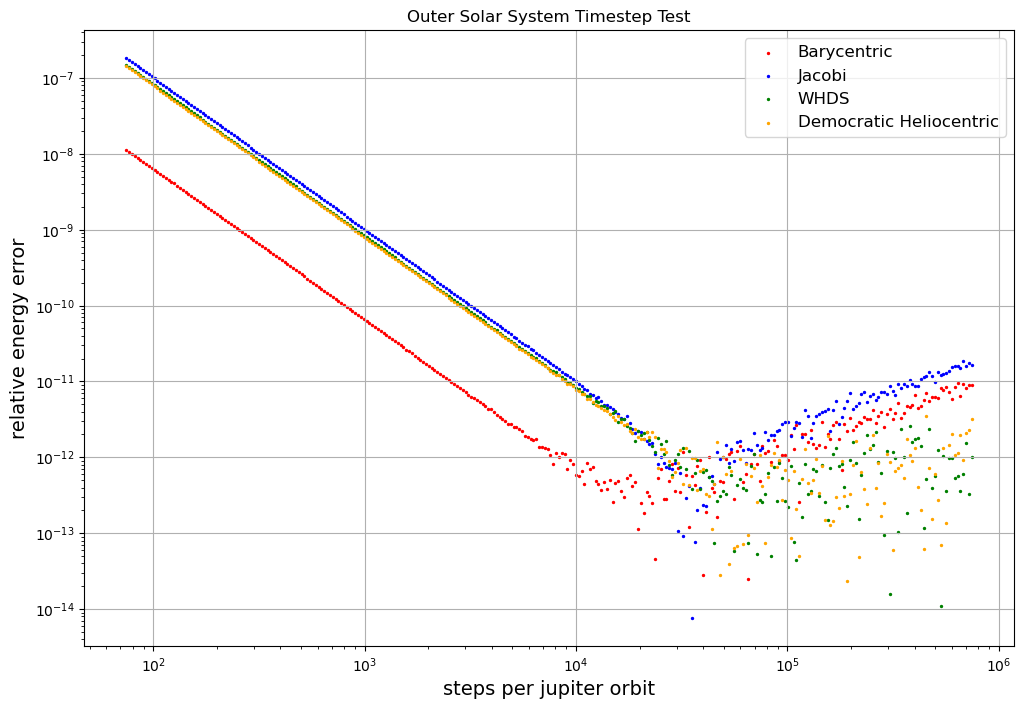

In [11]:
# Plot energy error vs timestep
fig = plt.figure(figsize=(12, 8))

colors = ["red", "blue", "green", "orange"]
coordinates = ["Barycentric", "Jacobi", "WHDS", "Democratic Heliocentric"]
for c, coord in enumerate(coordinates):
    plt.scatter(period/timesteps, final_errors[c], label=coord, color=colors[c],s=2)

plt.title("Outer Solar System Timestep Test")
plt.xlabel("steps per jupiter orbit", fontsize=14)
plt.ylabel("relative energy error", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(fontsize=12)
plt.show()
fig.savefig("outer_solar_system_timestep.pdf")


### 2-Body Problem Timestep Test

In [12]:
import rebound
from rebound import data
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import tqdm

timesteps = np.logspace(-4, 0, 200)
coordinates = ["barycentric", "jacobi", "whds", "democraticheliocentric"]
n_coords = len(coordinates)
final_errors = np.zeros((n_coords, len(timesteps)))
def run_sim(params):
    coord, dt = params
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=1.)
    sim.add(m=1.,a=1.,e=0.0)
    sim.move_to_com()
    period = sim.particles[1].P
    sim.ri_whfast.coordinates = coord
    sim.dt = dt    
    max_time = 1000 * period
    initial_energy = sim.energy()
    sim.integrate(max_time)
    final_error = np.abs((sim.energy() - initial_energy)/initial_energy)
    sim = None
    return coord, dt, final_error, period

coord_dt_pairs = [(coord, dt) for coord in coordinates for dt in timesteps]
with ProcessPoolExecutor(max_workers=24) as executor:
    results = list(tqdm.tqdm(executor.map(run_sim, coord_dt_pairs),total=len(coord_dt_pairs)))

period = results [0][3]
for coord, dt, error, _ in results:
    c_idx = coordinates.index(coord)
    dt_idx = np.where(timesteps == dt)[0][0]
    final_errors[c_idx, dt_idx] = error

100%|██████████| 800/800 [00:45<00:00, 17.61it/s]


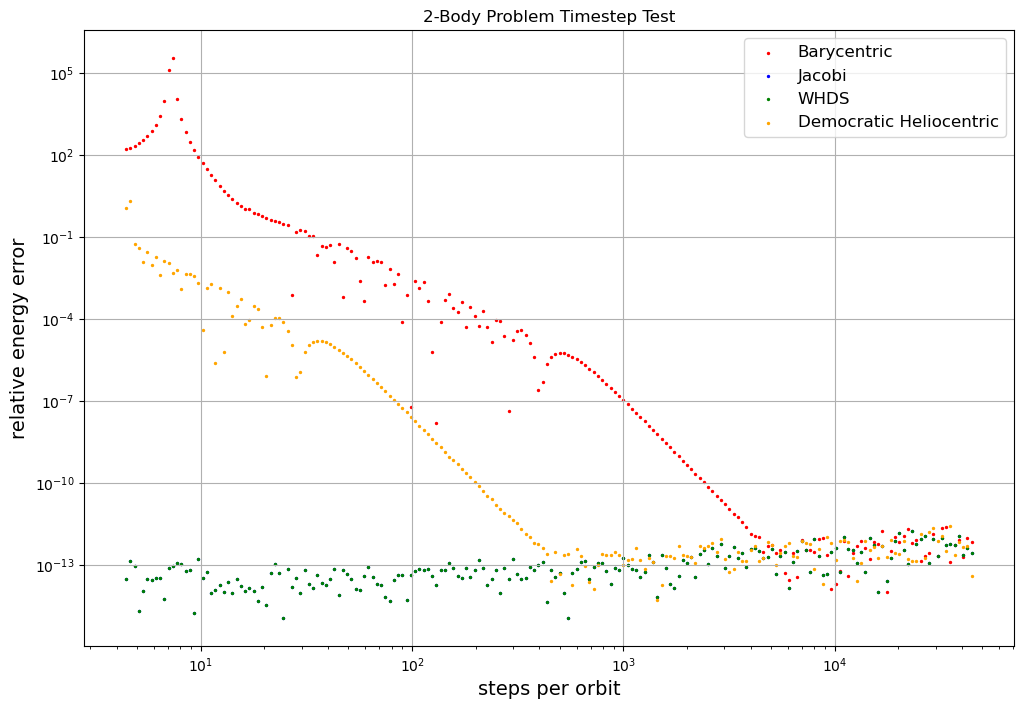

In [13]:
# Plot energy error vs timestep
fig = plt.figure(figsize=(12, 8))
colors = ["red", "blue", "green", "orange"]
coordinates = ["Barycentric", "Jacobi", "WHDS", "Democratic Heliocentric"]
for c, coord in enumerate(coordinates):
    plt.scatter(period/timesteps, final_errors[c], label=coord, 
             color=colors[c],s=2)

plt.title("2-Body Problem Timestep Test")
plt.xlabel("steps per orbit", fontsize=14)
plt.ylabel("relative energy error", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(fontsize=12)
plt.show()
fig.savefig("2body_timestep.pdf")